# Тестирую nms, не вшитый в onnx

### Импорт

In [1]:

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import onnx
from onnx import numpy_helper, TensorProto, checker
from onnx import helper as onnx_helper

import onnxruntime as onnx_run
import cv2

### Получаем изображение и смотрим на сырой inference

In [17]:
%matplotlib inline

In [2]:
session = onnx_run.InferenceSession('without_nms.onnx')
session

In [3]:
image = cv2.imread('DJI_0418-00000017.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# crop image
height, width = image.shape[:2]
startX = width // 2 - 320
startY = height // 2 - 320
endX = startX + 640
endY = startY + 640
image = image[startY:endY, startX:endX]

batch = np.moveaxis(image, -1, 0)[None, ...] / np.float32(255)

result = session.run(None, {'images': batch})
for sub in result:
    print(sub.shape)

(1, 3, 80, 80, 10)
(1, 3, 40, 40, 10)
(1, 3, 20, 20, 10)


In [4]:
from yolov7.models import yolo
import torch
import torchvision
from typing import List

### Код, который преобразует FpnHeads в Bbox

In [5]:

class PredIdx:
    """Provide names for each tensor idx for what constitutes a prediction"""

    CX = 0
    CY = 1
    W = 2
    H = 3
    OBJ = 4
    
    
class FpnHeadShapeIndex:
    BATCH = 0
    BOXES_PER_ANCHOR = 1
    X_BOXES = 2
    Y_BOXES = 3
    FEATURES = 4
    
def transform_model_outputs_into_predictions(outputs: torch.tensor) -> torch.tensor:
    """Transform model outputs into proper cx, cy, w, h

    For xy we apply a sigmoid and a translation from (0,1) -> (-0.5, 1.5). This means that the
    model can correct each anchor point to be 0.5 positions in the grid smaller or 1.5 positions
    bigger (i.e., move anchor to the middle of the following grid cell, for instance). This is
    also related to what anchors are considered as potential predictions in the loss (in the
    function `find_predicted_boxes`). How we select them are the boxes that the model could modify
    to put the anchor of the grid where the target anchor is.

    For wh, we effectively make the model be able to make anchor boxes from 0 to 4 times bigger
    than the original size. This seems to be related to the filter in size proportion we also
    do on the loss.

    :param outputs: Outputs of a fpn head, last dimension is 5 + num_classes (see PredIdx class).
    :return preds: Tensor of num_preds * (5 + num_classes)
    """
    preds_xy = outputs[..., [PredIdx.CX, PredIdx.CY]].sigmoid() * 2.0 - 0.5
    preds_wh = (outputs[..., [PredIdx.W, PredIdx.H]].sigmoid() * 2) ** 2
    preds_rest = outputs[..., PredIdx.OBJ :]
    preds = torch.cat([preds_xy, preds_wh, preds_rest], dim=-1)
    return preds

In [6]:
class PostProcessFpnHeads:
    def __init__(self):
        self.num_of_outputs = 10
        self.strides = [8, 16, 32]
    

    def postprocess(
        self,
        fpn_heads_outputs: List[torch.Tensor],
        conf_thres: float = 0.001,
        max_detections: int = 30000,
    ) -> List[torch.Tensor]:
        # old code with strides
        # fpn_head_x_boxes = [
        #     i.shape[FpnHeadShapeIndex.X_BOXES] for i in fpn_heads_outputs
        # ]
            
        # strides = input_shape[0] / fpn_head_x_boxes 

        preds = self._derive_preds(fpn_heads_outputs)
        formatted_preds = self._format_preds(
            preds, conf_thres, max_detections
        )
        return formatted_preds

    def _derive_preds(self, fpn_heads_outputs):
        all_preds = []
        for layer_idx, fpn_head_outputs in enumerate(
            fpn_heads_outputs
        ):
            batch_size, _, num_rows, num_cols, *_ = fpn_head_outputs.shape
            grid = self._make_grid(num_rows, num_cols)
            fpn_head_preds = transform_model_outputs_into_predictions(fpn_head_outputs)
            fpn_head_preds[
                ..., [PredIdx.CY, PredIdx.CX]
            ] += grid  # Grid corrections -> Grid coordinates
            
            fpn_head_preds[
                ..., [PredIdx.CX, PredIdx.CY]
            ] *= self.strides[
                layer_idx
            ]  # -> Image coordinates
            
            # self.detection_head.anchor_grid
            
            fpn_head_preds[
                ..., [PredIdx.W, PredIdx.H]
            ] *= self.strides[
                layer_idx
            ]  # Anchor box corrections -> Image coordinates
            
            fpn_head_preds[..., PredIdx.OBJ :].sigmoid_()
            all_preds.append(
                fpn_head_preds.view(batch_size, -1, self.num_of_outputs)
            )
        return torch.cat(all_preds, 1)

    @staticmethod
    def _make_grid(num_rows, num_cols):
        """Create grid with two stacked matrixes, one with col idxs and the other with row idxs"""
        meshgrid = torch.meshgrid(
            [torch.arange(num_rows), torch.arange(num_cols)], indexing="ij"
        )
        grid = torch.stack(meshgrid, 2).view((1, 1, num_rows, num_cols, 2)).float()
        return grid

    def _format_preds(
        self,
        preds,
        conf_thres=0.01,
        max_detections=1000,
    ):
        num_classes = preds.shape[2] - 5

        formatted_preds = [torch.zeros((0, 6))] * preds.shape[0]

        for image_idx, detections_for_image in enumerate(
            preds
        ):  # image index, image inference

            # filter by confidence
            detections_for_image = detections_for_image[
                detections_for_image[:, 4] >= conf_thres
            ]

            # If none remain process next image
            if not detections_for_image.shape[0]:
                continue

            if num_classes == 1:
                detections_for_image[:, 5:] = detections_for_image[
                    :, 4:5
                ]  # for models with one class, cls_loss is 0 and cls_conf is always 0.5,
                # so there is no need to multiply.
            else:
                detections_for_image[:, 5:] *= detections_for_image[
                    :, 4:5
                ]  # conf = obj_conf * cls_conf

            # Box non-normalized (center x, center y, width, height) to (x1, y1, x2, y2)
            xyxy_boxes = torchvision.ops.box_convert(
                detections_for_image[:, :4], "cxcywh", "xyxy"
            )

            
            # best class only
            # j, most confident class index
            class_conf, class_idxs = detections_for_image[:, 5:].max(
                1, keepdim=True
            )

            # filter by class confidence
            detections_for_image = torch.cat(
                (xyxy_boxes, class_conf, class_idxs), 1
            )[class_conf.view(-1) > conf_thres]

            # Check shape
            n = detections_for_image.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_detections:  # excess boxes
                detections_for_image = detections_for_image[
                    detections_for_image[:, 4].argsort(descending=True)[:max_detections]
                ]  # sort by confidence

            formatted_preds[image_idx] = detections_for_image

        return formatted_preds

Получаем predictions из fpn_heads

In [26]:
fpn_heads = session.run(None, {'images': batch})
fpn_heads = [torch.from_numpy(i) for i in fpn_heads]
post_process = PostProcessFpnHeads()
predictions = post_process.postprocess(fpn_heads, max_detections=2000)


1
torch.Size([2000, 6])


### Фильтруем предсказания при помощи nms

In [27]:

def filter_eval_predictions(
    predictions: List[torch.Tensor],
    confidence_threshold: float = 0.2,
    nms_threshold: float = 0.65,
) -> List[torch.Tensor]:
    nms_preds = []
    for pred in predictions:
        pred = pred[pred[:, 4] > confidence_threshold]

        nms_idx = torchvision.ops.batched_nms(
            boxes=pred[:, :4],
            scores=pred[:, 4],
            idxs=pred[:, 5],
            iou_threshold=nms_threshold,
        )
        nms_preds.append(pred[nms_idx])

    return nms_preds

In [33]:
nms_predictions = filter_eval_predictions(predictions, confidence_threshold=0.25, nms_threshold=0.35)
nms_predictions[0].shape


torch.Size([1349, 6])

In [ ]:
import matplotlib.colors as mcolors


normalizer = mcolors.Normalize(vmin=-2, vmax=2)
colormap = plt.get_cmap('')
normalizer(2)
colormap()

In [75]:
from functools import partial

import matplotlib.pyplot as plt
from matplotlib import patches


def get_rectangle_params_from_coco_bbox(bbox):
    x_min, y_min, width, height = bbox

    bottom_left = (x_min, y_min)

    return bottom_left, width, height


def get_rectangle_params_from_yolo_bbox(bbox):
    cx, cy, width, height = bbox

    x_min = cx - width / 2
    y_min = cy - height / 2

    bottom_left = (x_min, y_min)

    return bottom_left, width, height


def get_rectangle_params_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height


def draw_bboxes(
    plot_ax,
    bboxes,
    labels=None,
    class_labels=None,
    color_1="black",
    color_2="white",
    get_rectangle_corners_fn=get_rectangle_params_from_pascal_bbox,
):
    colors = plt.get_cmap('gist_earth')(range(len(labels)))[:, :3]
    
        

    if class_labels is not None:
        assert len(class_labels) == len(bboxes)
        # colors = plt.get_cmap('gist_earth')(range(len(class_labels)))[:, :3]
        # label_2_color_index = {}
        # sorted_labels = np.unique(class_labels).tolist()
        # sorted_labels.sort()
        # for ind, label in enumerate(sorted_labels):
        #     label_2_color_index[label] = ind
    else:
        class_labels = [None] * len(bboxes)
        # colors = plt.get_cmap('gist_earth')(range(len(bboxes)))[:, :3]

    for bbox, label in zip(bboxes, class_labels):
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        # color_index = 
        label = int(label)
        color = colors[label]
        rect_1 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=1,
            edgecolor=color,
            fill=False,
        )
        # rect_2 = patches.Rectangle(
        #     bottom_left,
        #     width,
        #     height,
        #     linewidth=1,
        #     edgecolor='black',
        #     fill=False,
        # )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        # plot_ax.add_patch(rect_2)

        if label is not None:
            rx, ry = rect_1.get_xy()
            # plot_ax.annotate(label, (rx, ry + height), color=color_2, fontsize=20)


draw_bboxes_coco = partial(
    draw_bboxes, get_rectangle_corners_fn=get_rectangle_params_from_coco_bbox
)

draw_bboxes_yolo = partial(
    draw_bboxes, get_rectangle_corners_fn=get_rectangle_params_from_yolo_bbox
)

draw_xyxy_bboxes = partial(
    draw_bboxes, get_rectangle_corners_fn=get_rectangle_params_from_pascal_bbox
)

draw_functions = {
    "coco": draw_bboxes_coco,
    "cxcywh": draw_bboxes_yolo,
    "xyxy": draw_xyxy_bboxes,
}


def annotate_image(
    image, bboxes=None, class_labels=None, labels=None, bbox_format="xyxy", close_fig=True
):
    draw_bboxes_fn = draw_functions[bbox_format]

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    if bboxes:
        draw_bboxes_fn(ax, bboxes=bboxes, class_labels=class_labels, labels=labels)

    if close_fig:
        plt.close(fig)

    return fig


def show_image(image, bboxes=None, class_labels=None, labels=None, bbox_format="xyxy"):
    fig = annotate_image(
        image,
        bboxes=bboxes,
        class_labels=class_labels,
        labels=labels,
        bbox_format=bbox_format,
        close_fig=False,
    )
    plt.show()

In [83]:
fpn_heads = session.run(None, {'images': batch})
fpn_heads = [torch.from_numpy(i) for i in fpn_heads]
post_process = PostProcessFpnHeads()
predictions = post_process.postprocess(fpn_heads, max_detections=20000, conf_thres=0.01)
predictions[0].shape

torch.Size([12045, 6])

In [97]:
nms_predictions = filter_eval_predictions(predictions, confidence_threshold=0.2, nms_threshold=0.15)
nms_predictions[0].shape

torch.Size([1734, 6])

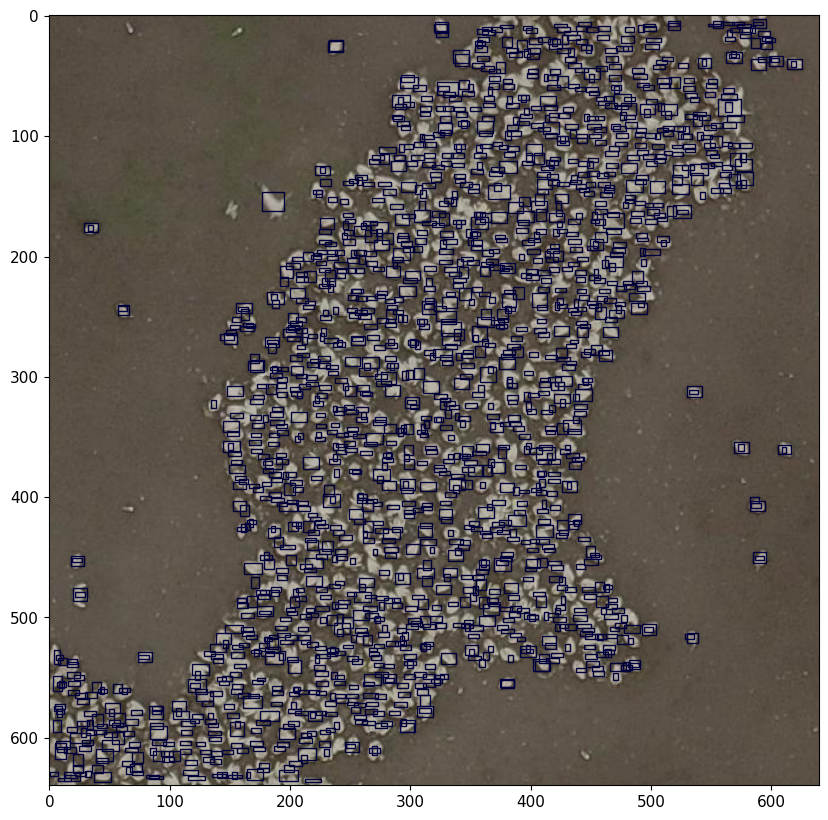

In [98]:
bboxes=nms_predictions[0][:, :4]
class_labels=nms_predictions[0][:, -1]

show_image(
    image,
    bboxes=bboxes.tolist(), 
    labels = ['nest', 'subcolony', 'adult', 'hatchling', 'unknown'],
    class_labels=class_labels.tolist())

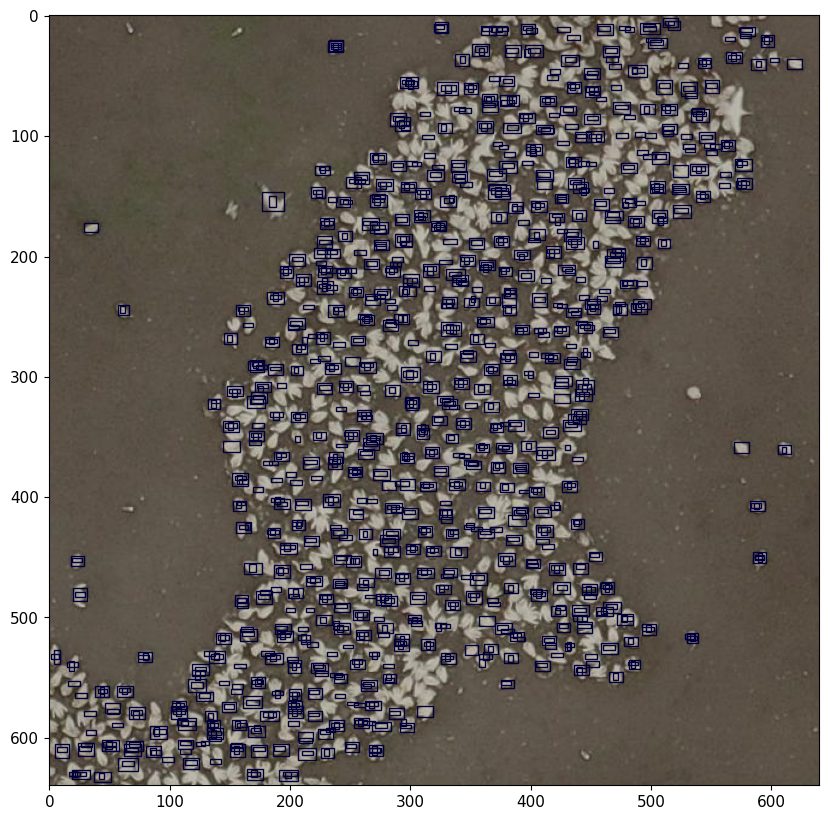

In [87]:
bboxes=nms_predictions[0][:, :4]
class_labels=nms_predictions[0][:, -1]

show_image(
    image,
    bboxes=bboxes.tolist(), 
    labels = ['nest', 'subcolony', 'adult', 'hatchling', 'unknown'],
    class_labels=class_labels.tolist())